# Proxy App to Identify Cascade Failures

## Import Modules

In [1]:
# Standard Libraries
import numpy as np
import tensorflow as tf

tf.keras.backend.clear_session()
tf.keras.backend.set_floatx('float64')
print("[INFO] Tensorflow version: ", tf.__version__)
print("[INFO] Eager mode: ", tf.executing_eagerly()) # For easy reset of notebook state.

[INFO] Tensorflow version:  2.3.0
[INFO] Eager mode:  True


In [2]:
# Custom Library
import sys
sys.path.append('../../')

from proxy_apps.apps.cascade_failure import deepDMD
from proxy_apps.plot_lib.simple_plots import eigen_plot, validation_plot, heatmap_matplotlib

## Data Loading and Preprocessing
The input data for the model should be in the form of array. The output array (Y) will have same number of features as the input array (X) but Y would be a time shifted version of the X. In the case of DeepDMD, the shift was equal to 1. In the original application, the data is not sequential and rather restructured using rolling window.

In [3]:
# arrays after implementing rolling window
X_array = np.random.rand(480000, 136)
Y_array = np.random.rand(480000, 136)

# original array without windowing
Yp_array = np.random.rand(29970, 136)
Yf_array = np.random.rand(29970, 136)

In [4]:
X_array

array([[0.69253798, 0.55562489, 0.47203583, ..., 0.9507323 , 0.56066055,
        0.69192162],
       [0.60571405, 0.62901749, 0.82538891, ..., 0.61674585, 0.03102763,
        0.95695689],
       [0.94403765, 0.95462656, 0.5718495 , ..., 0.28511543, 0.2742679 ,
        0.90501633],
       ...,
       [0.97363933, 0.05186222, 0.41561816, ..., 0.02655421, 0.00415177,
        0.60071833],
       [0.45093132, 0.40014894, 0.78464204, ..., 0.83970294, 0.6439055 ,
        0.38031032],
       [0.56604291, 0.94302545, 0.213779  , ..., 0.54160052, 0.69781431,
        0.45277761]])

## Data Modeling

In [5]:
# Hyperparameters
hyper_param_dict = dict()
hyper_param_dict['original_dim']       = 136   # input data dimension
hyper_param_dict['hl_1_dim']           = 128   # Hidden layer dimension
hyper_param_dict['hl_2_dim']           = 128   # Hidden layer dimension
hyper_param_dict['hl_3_dim']           = 64   # Hidden layer dimension
hyper_param_dict['hl_4_dim']           = 64   # Hidden layer dimension
# hyper_param_dict['hl_5_dim']           = 64   # Hidden layer dimension
hyper_param_dict['latent_dim']         = 64 # Latent space dimension 
hyper_param_dict['reg_factor']         = 0 # regularization weight for Koopman
hyper_param_dict['dropout_prob']       = 0.005  # dropout rate [regularization between hidden layers]
hyper_param_dict['weight_regularizer'] = 0.001  # [L1] regularization weight for dense layer weights 
hyper_param_dict['bias_regularizer']   = 0    # [L1] regularization bias for dense layer biases
hyper_param_dict['num_epochs']         = 1  # Number of epochs 
hyper_param_dict['learning_rate']      = 5e-4 # learning rate for optimizer 
hyper_param_dict['validation_split']   = 0.25
hyper_param_dict['batch_size']         = 32

# Initialize Hyperparameters - we can keep it as a dict instead of creating a separate class
hp = deepDMD.HyperParameters(hyper_param_dict)

In [6]:
# Stopping criteria if the training loss doesn't go down by 1e-3
CallBack = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta = 1e-3, verbose = 1, mode='min', patience = 3, 
    baseline=None, restore_best_weights=True)
K_model = deepDMD.NeuralNetworkModel(hp)
K_model.compile(optimizer=tf.optimizers.Adagrad(hp.lr))
history = K_model.fit([X_array, Y_array], validation_split = hp.vs, batch_size = hp.bs, 
                   epochs=hp.ep, callbacks=[CallBack], shuffle = True)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
11250/11250 [==============================] - 43s 4ms/step - loss: 24.9677 - val_loss: 23.9666


## Model Evaluation

Koopman loss: 666.4382
Psi_X shape: (29970, 64)
Psi_Y shape: (29970, 64)
PSI_X shape: (29970, 200)
PSI_X shape: (29970, 200)


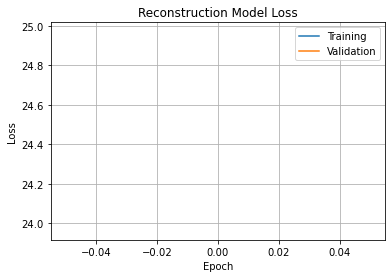

In [7]:
Psi_X, PSI_X, Psi_Y, PSI_Y, Kloss = K_model([Yp_array, Yf_array], training=False)
print("Koopman loss: %.4f" %Kloss.numpy())

print('Psi_X shape:', Psi_X.numpy().shape)
print('Psi_Y shape:', Psi_Y.numpy().shape)
print('PSI_X shape:', PSI_X.numpy().shape)
print('PSI_X shape:', PSI_Y.numpy().shape)

# Plot training & validation loss values
validation_plot(history)

### Find the Koopman operator and check its eigenvalues and sparsity structure 

[INFO]: Shape of Koopman operator (200, 200)
[INFO]: Norm of Koopman operator 8.548447111991099
[INFO]: Trace of K_deepDMD: 1.9486373685747878
[INFO]: One time-step error with K_deepDMD: 666.4381985699013


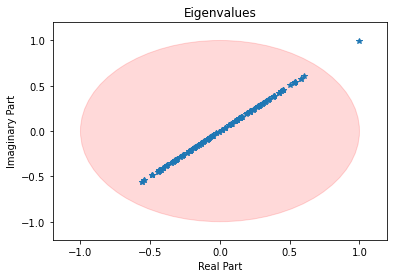

In [8]:
K_deepDMD = K_model.KO.numpy()

print('[INFO]: Shape of Koopman operator', K_deepDMD.shape)
print('[INFO]: Norm of Koopman operator', np.linalg.norm(K_deepDMD))
print('[INFO]: Trace of K_deepDMD:',np.trace(K_deepDMD))
print('[INFO]: One time-step error with K_deepDMD:', np.linalg.norm(PSI_Y - np.matmul(PSI_X, K_deepDMD), ord = 'fro'))

[eigenvaluesK, eigenvectorsK] = np.linalg.eig(K_deepDMD)
eigen_plot(eigenvaluesK.real, eigenvaluesK.imag)

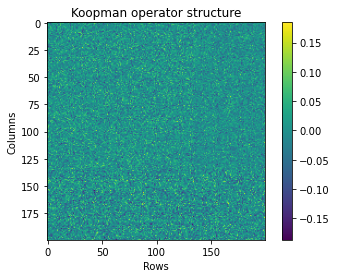

In [10]:
heatmap_matplotlib(K_deepDMD, title='Koopman operator structure')

### Get the neural network weights
- These weights are obtained after adding weight regularization. One can compare these weights with the neural network weights without any weight regularization. We can clearly see sparse structure here. 

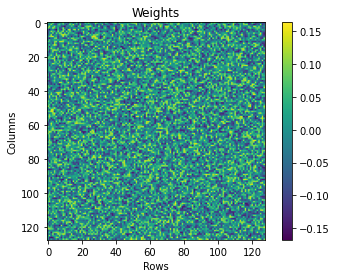

In [11]:
weights = K_model.get_weights()
heatmap_matplotlib(weights[2], title='Weights')